# 46 kNN
## 46.1 kNN原理

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import logging

# 生成 25 × 2 的矩阵（坐标），每个元素∈[0, 100)
trainData = np.random.randint(0, 100, (25, 2)).astype(np.float32)
# 生成 25 × 1 的矩阵（颜色），每个元素∈[0, 2)
responses = np.random.randint(0, 2, (25, 1)).astype(np.float32)
# 以上两步其实生成了 25 × 3 的矩阵，每一行为(x, y color)

# responses.ravel() == 0 返回一个Boolean序列
# red 为color==0的所有行
red = trainData[responses.ravel() == 0]

# red[:, 0]、red[:, 1] 提取所有行的x列 和 y列
# 参数3、参数4、参数5 绘制大小、颜色、形状
plt.scatter(red[:, 0], red[:, 1], 10, 'r', '^')

red

array([[ 90.,  19.],
       [ 83.,  86.],
       [ 79.,  29.],
       [ 73.,  30.],
       [ 38.,  47.],
       [ 62.,   0.],
       [  2.,  82.],
       [ 62.,  41.],
       [ 60.,  41.],
       [ 64.,  80.],
       [ 96.,  70.],
       [ 94.,  88.],
       [ 78.,   3.],
       [ 59.,   8.]], dtype=float32)

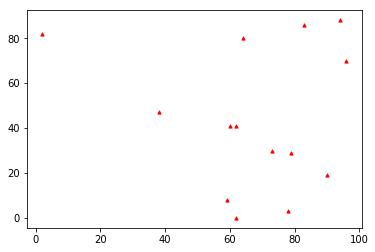

In [2]:
plt.show()

In [3]:
# 与red同理
blue = trainData[responses.ravel() == 1]
plt.scatter(blue[:, 0], blue[:, 1], 10, 'b', 's')

In [4]:
blue

array([[ 88.,  49.],
       [ 26.,  82.],
       [ 46.,  46.],
       [ 51.,  66.],
       [ 54.,  88.],
       [ 81.,  20.],
       [ 27.,  25.],
       [ 81.,  18.],
       [ 62.,  51.],
       [ 37.,  30.],
       [ 45.,  15.]], dtype=float32)

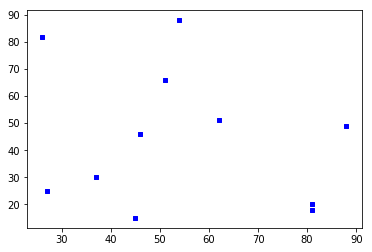

In [5]:
plt.show()

In [6]:
# 随机生成newcomer的x、y坐标
newcomer = np.random.randint(0, 100, (5, 2)).astype(np.float32)
plt.scatter(newcomer[:, 0], newcomer[:, 1], 20, 'g', 'o')

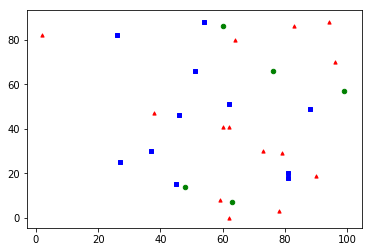

In [8]:
knn = cv2.ml.KNearest_create()
knn.train(trainData, cv2.ml.ROW_SAMPLE, responses)
ret, results, neighbours, dist = knn.findNearest(newcomer, 3)

results # 预测newcomer的颜色
neighbours # 与newcomer邻近的3个点的颜色
dist  # 与newcomer邻近的3个点的距离


plt.scatter(red[:, 0], red[:, 1], 10, 'r', '^')
plt.scatter(blue[:, 0], blue[:, 1], 10, 'b', 's')
plt.scatter(newcomer[:, 0], newcomer[:, 1], 20, 'g', 'o')
plt.show()

## 46.2.1 使用kNN对手写数字OCR
按照上一节的原理，把包含5000个数字的1张大图符切割成20×20的5000张小图，每张图片又可视为400维的数据。分出2500张作为训练集，即在400维的空间中标出10种类型的点，每种点有50个样本，这就是训练过程。预测就是给定一个400维的测试数据，根据它与邻居之间的距离关系判断它属于哪一类。

In [9]:
img = cv2.imread('images/digits.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 将大图 50行×100列 分成5000张小图
cells = [np.hsplit(row, 100) for row in np.vsplit(gray, 50)]
# 将cells装到numpy array中，这是一个[50, 100, 20, 20]的数组
x = np.array(cells)

# 分出前50列共2500张图，重新组织成2500张每张图400个像素的训练数据
train = x[:, :50].reshape(-1, 400).astype(np.float32)
# 重新组织测试数据，共2500张图
test = x[:, 50:100].reshape(-1, 400).astype(np.float32)

# 为训练数据和测试数据创建labels
k = np.arange(10)
trainLabels = np.repeat(k, 250)[:, np.newaxis]
testLabels = trainLabels.copy()

knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, trainLabels)
ret, results, neighbours, dist = knn.findNearest(test, k=5)

matches = results == testLabels
correct = np.count_nonzero(matches)
accuracy = correct * 100.0 / results.size

accuracy

91.76

挑选一张测试图片：

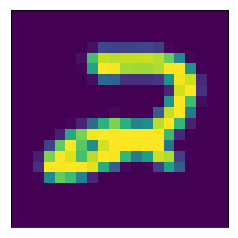

In [15]:
testcase = test[502]
plt.imshow(testcase.reshape(20, 20))
plt.xticks([]), plt.yticks([])
plt.show()

识别该图片：

In [16]:
ret, results, neighbours, dist = knn.findNearest(np.array([testcase]), k=5)

results

array([[ 2.]], dtype=float32)

## 46.2.2 英文字母的OCR
数据来自http://archive.ics.uci.edu/ml/datasets/Letter+Recognition
它采集了26个大写字母的20中不同字体，并且通过扭曲处理生成20,000个采样数据。将样本图片抽象成16个可数字化的属性。数据文件letter-recognition.data是一个文本文件，它包含了这16个属性，形式为：
`T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8`
各列含义为：

1. 大写字母（从A到Z有26个值）
2. 框的左边缘的x坐标（整数）
3. 框的顶部y坐标（整数）
4. 框的宽度（整数）
5. 框高度（整数）
6. onpix总像素数（整数）
7. 框中像素的x-均值（整数）
8. 框中像素的y-均值（整数）
9. x2bar平均值方差（整数）
10. y2bar平均值方差（整数）
11. xybar mean x y相关性（整数）
12. x²ybr的平均值x · x · y（整数）
13. xy²br平均值x · y · y（整数）
14. x-ege平均边数从左到右（整数）
15. x-ege与y的整数相关（整数）
16. y-ege平均边数从下到上（整数）
17. y-ege与x（整数）的yegvx相关性